In [1]:
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/subject05.npz &> /dev/null

Syntaxfehler.
Syntaxfehler.


In [2]:
import MRzeroCore as mr0
import matplotlib.pyplot as plt
from numpy import pi
import torch

c:\Users\endresjn\Documents\MRzero\MRzero-Core\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(flash)=
# Create a FLASH Sequence

This Notebook demonstrates a simple Fast Low Angle SHot sequence (FLASH). It is a simple gradient echo sequence with low TR and flip angles typically below 10°.

Always prefer to write a function that builds the sequence that takes all variables of interest (often flip angles, TE, TR and/or others) as arguments. This way one can easily build variations of the sequence or optimize the arguments with gradient descent when using pyTorch tensors for all variables.

In [3]:
def build_seq(alpha=7, phi=137.50776405) -> mr0.Sequence:
    seq = mr0.Sequence()

    enc = torch.randperm(64) - 32

    for i in range(64):
        rep = seq.new_rep(2 + 64 + 1)
        rep.pulse.usage = mr0.PulseUsage.EXCIT
        rep.pulse.angle = alpha * pi/180
        rep.pulse.phase = 0.5 * phi * (i**2+i+2) * pi / 180

        rep.event_time[0] = 2e-3  # Pulse
        rep.event_time[1] = 2e-3  # Rewinder
        rep.event_time[2:-1] = 0.08e-3  # Readout
        rep.event_time[-1] = 2e-3  # Spoiler

        rep.gradm[1, 0] = -33
        rep.gradm[2:-1, 0] = 1
        rep.gradm[-1, 0] = 96 - 31

        # Linear reordered phase encoding
        rep.gradm[1, 1] = i - 32
        # rep.gradm[1, 1] = i // 2 if i % 2 == 0 else -(i + 1) // 2
        # rep.gradm[1, 1] = enc[i]
        rep.gradm[-1, 1] = -rep.gradm[1, 1]

        rep.adc_usage[2:-1] = 1
        rep.adc_phase[2:-1] = pi - rep.pulse.phase

    return seq

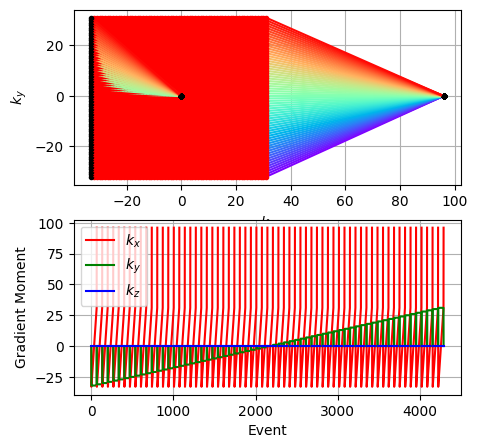

In [4]:
# Build the default FLASH and show the kspace
seq = build_seq()
seq.plot_kspace_trajectory()

# Until now, the sequence uses normalized grads: The simulation will adapt them
# to the phantom size. If we want to hardcode a fixed FOV instead, we can do so:
seq.normalized_grads = False
for rep in seq:
    rep.gradm[:] /= 200e-3  # 200 mm FOV

VoxelGridPhantom
size = tensor([0.1500, 0.1500, 1.0000])


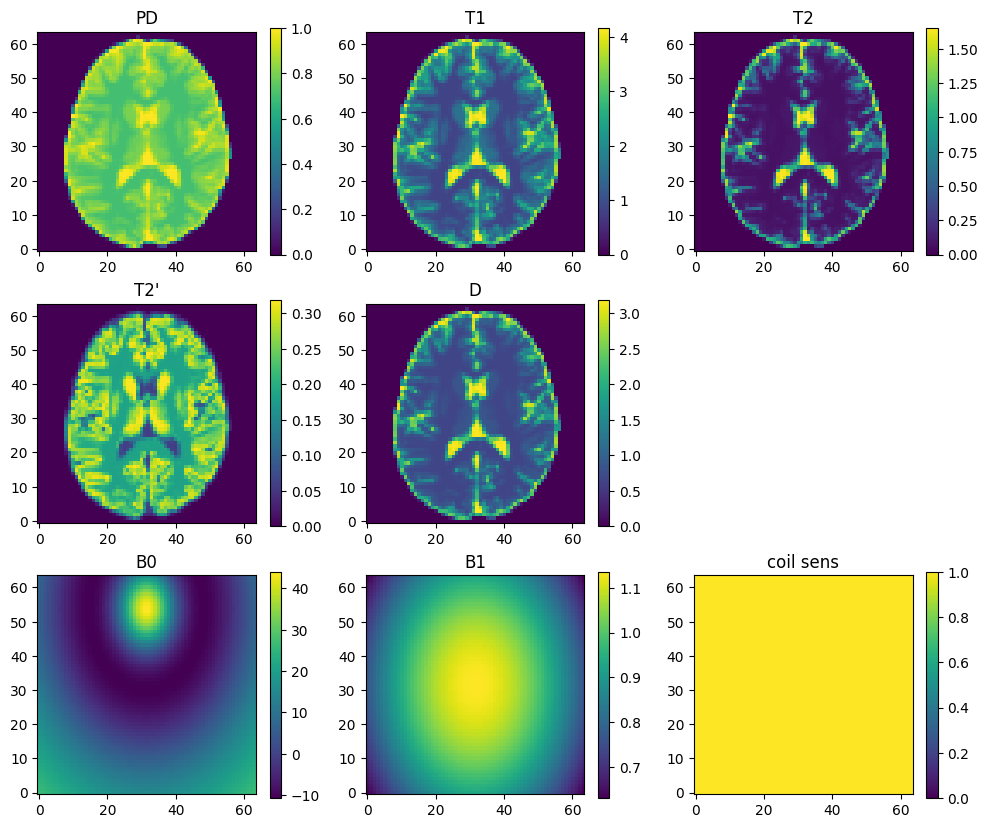

In [5]:
# Load a BrainWeb phantom for simulation

# https://github.com/MRsources/MRzero-Core/raw/main/documentation/examples/subject05.npz

phantom = mr0.VoxelGridPhantom.brainweb("subject05.npz")
phantom = phantom.interpolate(64, 64, 32).slices([16])
# The default fov is loaded from the data, but we can change it:
phantom.size = torch.tensor([0.15, 0.15, 1])

phantom.plot()
data = phantom.build()


def phantom_motion(time: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
    time /= 0.712  # Sequence duration

    phi = 0.8 * time
    x = -0.03 * time**2
    y = 0 * time

    phi = torch.as_tensor(phi)
    cos = torch.cos(phi)
    sin = torch.sin(phi)

    # We can't construct tensors directly as this would remove gradients
    offset = torch.zeros(time.numel(), 3)
    offset[:, 0] = x
    offset[:, 1] = y

    rot = torch.zeros(time.numel(), 3, 3)
    rot[:, 0, 0] = cos
    rot[:, 0, 1] = sin
    rot[:, 1, 0] = -sin
    rot[:, 1, 1] = cos
    rot[:, 2, 2] = 1

    return rot, offset


# data.phantom_motion = phantom_motion

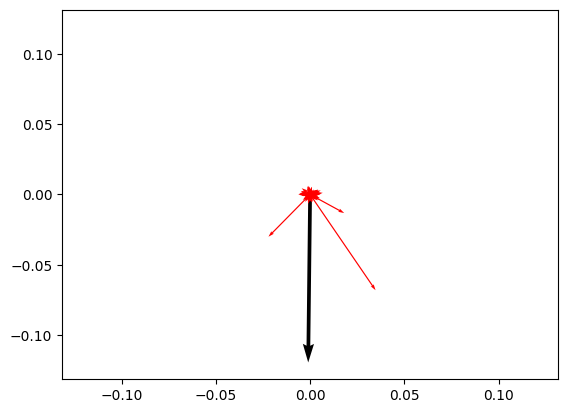

In [6]:
import numpy as np

# We can extract the information from the pre-pass graph
seq = build_seq(20, 117)
graph = mr0.compute_graph(seq, data)

# We try to find out how the magnetization of the state was created.
# We can do this by recursively visiting its ancestor states and their ancestors...
# This is not 100% accurate because the data does not include relaxation, but
# it should be good enough for understanding phase cycling.

def get_ancestor_mags(state, depth):
    if depth == 0 or len(state.ancestors) == 0:
        # no ancestors must be z0, lets include it as well
        return [state.prepass_mag]
    else:
        return [
            factor * mag
            for (_, ancestor_state, factor) in state.ancestors
            for mag in get_ancestor_mags(ancestor_state, depth - 1)
        ]

# Select a repetition to keep the code simple (you can iterate over all later)
rep = 20
# Find the state for this rep that is measured (has the most emitted signal)
state = max(graph[rep], key=lambda x: x.emitted_signal)
# Get all magnetizations that contributed to it (stepping 'depth' steps back)
depth = 10  # !!! WORST CASE exponential growing number of arrows!
mags = get_ancestor_mags(state, depth)

# Plot everything: the final mag in black, its components in red
zero = np.zeros(len(mags))
config = {'angles': 'xy', 'scale_units': 'xy', 'scale': 1}
lim = 1.1 * abs(state.prepass_mag)

plt.figure()
plt.quiver(0, 0, state.prepass_mag.real, state.prepass_mag.imag, **config)
plt.quiver(zero, zero, [m.real for m in mags], [m.imag for m in mags], **config, color="red")
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

In [7]:
# Simulate the sequence

formula = {}
seq = build_seq(20, 117)
graph = mr0.compute_graph(seq, data)
signal = mr0.execute_graph(graph, seq, data, formula)
reco = mr0.reco_adjoint(signal, seq.get_kspace())

for i in range(5):
    print()
    for dist in graph[i]:
        if dist in formula:
            print(f"({dist.dist_type:2}) = {formula[dist]}")

Calculating repetition 1 / 64

TypeError: '>=' not supported between instances of 'float' and 'dict'

Calculating repetition 64 / 64 - done
Detected FOV: (1.0, 1.0, 1.0)
Detected resolution: (64, 64, 1)


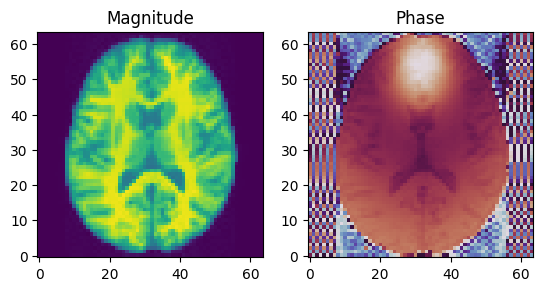

In [9]:
# Plot the result
seq = build_seq(20, 117)
graph = mr0.compute_graph(seq, data)
signal, mag_p = mr0.execute_graph(graph, seq, data, return_mag_p=True)
reco = mr0.reco_adjoint(signal, seq.get_kspace())

plt.figure()
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco.abs().cpu()[:, :, 0].T, origin='lower', vmin=0)
plt.subplot(122)
plt.title("Phase")
import numpy as np
plt.imshow(reco.angle().cpu()[:, :, 0].T, origin='lower', vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.show()

In [24]:
rep = 10
state = 0
print(sum([x.mean() for x in mag_p[rep][state]]))
print(graph[rep + 1][0].prepass_mag)

tensor(0.0976+0.0332j)
(0.5406560301780701+0j)


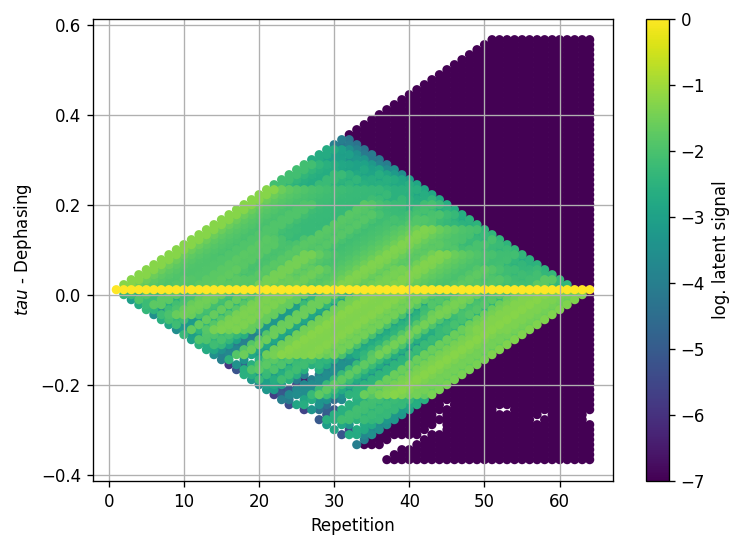

In [ ]:
plt.figure(figsize=(7, 5), dpi=120)
graph.plot()
plt.grid()
plt.show()